In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from colorama import Fore

In [2]:
# predictions = pd.read_csv('training_data_non_model.csv')
predictions = pd.read_csv('testing_data_non_model.csv')
increase_factor = 1.5

In [3]:
predictions.index = pd.to_datetime(predictions['Date'])

In [4]:
dataset = predictions.copy()

In [5]:
dataset["new_rfr"] = dataset["daily_risk_free_rate"] * increase_factor

In [6]:
# use the EWMA to do the trading strategy
def ewma(data, window):
    return data.ewm(span=window).mean()

fast_window = 50
slow_window = 90

dataset['fast'] = ewma(dataset['Close'], fast_window)
dataset['slow'] = ewma(dataset['Close'], slow_window)

In [7]:
def get_signals(data: pd.DataFrame) -> pd.DataFrame:
    dataset = data.copy()
    dataset['signal'] = 0
    for i in range(1, len(dataset)):
        
        # short signal
        if dataset['fast'].iloc[i] < dataset['slow'].iloc[i] and dataset['fast'].iloc[i-1] > dataset['slow'].iloc[i-1]:
            dataset.loc[dataset.index[i], 'signal'] = -1
        
        # buy signal
        elif dataset['fast'].iloc[i] > dataset['slow'].iloc[i] and dataset['fast'].iloc[i-1] < dataset['slow'].iloc[i-1]:
            dataset.loc[dataset.index[i], 'signal'] = 1
    return dataset

dataset = get_signals(dataset)

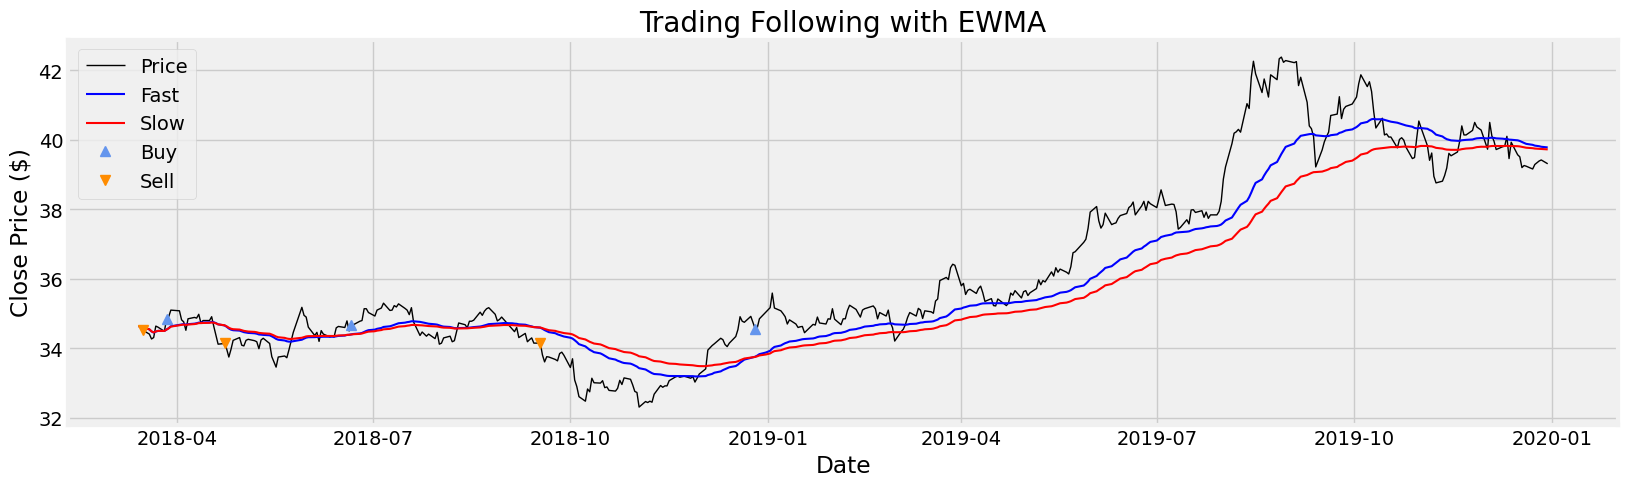

In [8]:
plt.figure(figsize=(20, 5))
plt.style.use('fivethirtyeight') 

plt.title('Trading Following with EWMA')

# Plot main price line
plt.plot(dataset.index, dataset['Close'], label='Price', color='black', linewidth=1)  # Thicker price lin

# Differentiate buy and sell signals with markers and colors
buy_signals = dataset[dataset['signal'] == 1].index
sell_signals = dataset[dataset['signal'] == -1].index

# Plot fast and slow EWMAs
plt.plot(dataset.index, dataset['fast'], label='Fast', color='blue', linewidth=1.5)  # Thinner EWMA lines
plt.plot(dataset.index, dataset['slow'], label='Slow', color='red', linewidth=1.5)

plt.plot(buy_signals, dataset['Close'][buy_signals], marker='^', linestyle='', color='cornflowerblue', label='Buy', markersize=7) 
plt.plot(sell_signals, dataset['Close'][sell_signals], marker='v', linestyle='', color='darkorange', label='Sell', markersize=7)

plt.xlabel(xlabel='Date')
plt.ylabel(ylabel='Close Price ($)')

plt.legend()
plt.show()

In [9]:
inital_cash = 200000
leverage_factor = 10

margin = [inital_cash]
margin_high = [inital_cash]

position = [0]

cash = [inital_cash]
cash_high = [inital_cash]

previous_signal = 0
re = [0]

bank_account = [0]
high_bank_account = [0]

for i in range(0, len(dataset)-1):
    current_signal = dataset['signal'].iloc[i]
    current_price = dataset['Close'].iloc[i]
    
    current_rfr = dataset['daily_risk_free_rate'].iloc[i]
    current_high_rfr = dataset['new_rfr'].iloc[i]
    
    current_position = position[-1]
    
    current_cash = cash[-1]
    current_cash_high = cash_high[-1]
    
    current_bank_account = bank_account[-1]
    current_high_bank_account = high_bank_account[-1]
    
    current_margin = margin[-1]
    current_margin_high = margin_high[-1]
    
    current_re = re[-1]
    
    if abs(current_position * current_price) > current_margin * leverage_factor:
        if current_position > 0:
            excess_return = current_position * current_price - current_margin * leverage_factor
            excess_stock = excess_return / current_price
            current_position -= excess_stock
            current_bank_account += excess_return
        elif current_position < 0:
            excess_return = -current_position * current_price - current_margin * leverage_factor
            excess_stock = excess_return / current_price
            current_position += excess_stock
    
    if current_position > 0:
        current_re = (current_price - previous_price) / previous_price
        today_profits = (current_position * previous_price) * (current_re - current_rfr)
        today_profits_highrfr = (current_position * previous_price) * (current_re - current_high_rfr)
        
        current_margin += today_profits
        current_margin_high += today_profits_highrfr
    
    if current_position < 0:
        
        current_re = (previous_price - current_price) / previous_price
        today_profits = (current_position * previous_price) * (current_re + current_rfr)
        today_profits_highrfr = (current_position * previous_price) * (current_re + current_high_rfr)
        
        current_margin += today_profits
        current_margin_high += today_profits_highrfr
    
    if current_signal == 1:
        # if we are already in a short position, then we close the short position
        if previous_signal == -1:
            current_position = 0
            previous_signal = 0
            
        # if we closed the short position, or we are in a initial position, then we buy
        if previous_signal == 0:
        
            stock_to_buy = (current_margin * leverage_factor) / current_price
            current_position += stock_to_buy
            long_price = current_price
            
            previous_signal = 1

    if current_signal == -1:
        if previous_signal == 1:
            current_position = 0
            previous_signal = 0
        
        if previous_signal == 0:
            
            stock_to_borrow = (current_margin * leverage_factor) / current_price
            current_position -= stock_to_borrow
            short_price = current_price
            
            previous_signal = -1
            
    previous_price = current_price
    
    current_high_bank_account = current_bank_account
    
    current_interest = current_bank_account * current_rfr
    current_high_interest = current_high_bank_account * current_high_rfr
    
    current_bank_account += current_interest
    current_high_bank_account += current_high_interest
    
    current_cash = current_bank_account
    current_cash += current_margin
    
    current_cash_high = current_high_bank_account
    current_cash_high += current_margin_high
    
    re.append(current_re)
    
    margin.append(current_margin)
    margin_high.append(current_margin_high)
    
    position.append(current_position)
    
    cash.append(current_cash)
    cash_high.append(current_cash_high)
    
    bank_account.append(current_bank_account)
    high_bank_account.append(current_high_bank_account)

current_price = dataset['Close'].iloc[-1]
current_bank_account = bank_account[-1]

current_interest = current_bank_account * current_rfr
current_high_interest = current_high_bank_account * current_high_rfr

current_bank_account += current_interest
current_high_bank_account += current_high_interest

current_margin = margin[-1]
current_margin_high = margin_high[-1]

current_position = position[-1]

current_cash = cash[-1]
current_cash_high = cash_high[-1]

if current_position > 0:
    current_re = (current_price - previous_price) / previous_price
    
    profits = (current_position * previous_price) * (current_re - current_rfr)
    profits_high = (current_position * previous_price) * (current_re - current_high_rfr)
    
    current_margin += profits
    current_margin_high += profits_high
    
    current_position = 0
    
if current_position < 0:
    
    current_re = (previous_price - current_price) / previous_price
    
    profits = (current_position * previous_price) * (current_re + current_rfr)
    profits_high = (current_position * previous_price) * (current_re + current_high_rfr)
    
    current_margin += profits
    current_margin_high += profits_high
    
    current_position = 0
    
current_cash = current_bank_account
current_cash += current_margin

current_cash_high = current_high_bank_account
current_cash_high += current_margin_high

position.append(current_position)

bank_account.append(current_bank_account)
high_bank_account.append(current_high_bank_account)

re.append(current_re)

margin.append(current_margin)
margin_high.append(current_margin_high)

cash.append(current_cash)
cash_high.append(current_cash_high)

In [10]:
report_df = pd.DataFrame({
    'margin': margin[1:],
    "margin_high_rfr": margin_high[1:],
    'position': position[1:],
    'cash': cash[1:],
    "cash_with_high_rfr": cash_high[1:],
    "bank_account": bank_account[1:],
    "bank_account_with_high_rfr": high_bank_account[1:],
    'excess_return': re[1:],
})
report_df.index = dataset.index

In [11]:
target_data = dataset.copy()
target_data = target_data.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close', 'fast', 'slow', "excess return", "return"])
final_result = pd.concat([target_data, report_df], axis=1)

In [12]:
final_result["theta"] = final_result["position"] * final_result["Close"]

final_result["pnl"] = final_result["margin"] - final_result["margin"].shift(1)
final_result["pnl_capital"] = final_result["bank_account"] - final_result["bank_account"].shift(1)
final_result["pnl_total"] = final_result["cash"] - final_result["cash"].shift(1)

final_result["cumulative_pnl"] = final_result["pnl"].cumsum()
final_result["cumulative_pnl_capital"] = final_result["pnl_capital"].cumsum()
final_result["cumulative_pnl_total"] = final_result["pnl_total"].cumsum()

final_result["turn_over_theta"] = abs(final_result["theta"] - final_result["theta"].shift(1))
final_result["turn_over_theta"] = final_result["turn_over_theta"].fillna(0)
final_result["cumulative_turn_over_theta"] = final_result["turn_over_theta"].cumsum()
final_result["turn_over_units"] = abs(final_result["position"] - final_result["position"].shift(1))
final_result["turn_over_units"] = final_result["turn_over_units"].fillna(0)
final_result["Upper_bound"] = final_result["margin"] * leverage_factor
final_result["Lower_bound"] = -final_result["margin"] * leverage_factor

final_result["pnl_150"] = final_result["margin_high_rfr"] - final_result["margin_high_rfr"].shift(1)
final_result["pnl_capital_150"] = final_result["bank_account_with_high_rfr"] - final_result["bank_account_with_high_rfr"].shift(1)
final_result["pnl_total_150"] = final_result["cash_with_high_rfr"] - final_result["cash_with_high_rfr"].shift(1)

final_result["cumulative_pnl_150"] = final_result["pnl_150"].cumsum()
final_result["cumulative_pnl_capital_150"] = final_result["pnl_capital_150"].cumsum()
final_result["cumulative_pnl_total_150"] = final_result["pnl_total_150"].cumsum()
final_result.fillna(0, inplace=True)

In [13]:
# final_result.to_csv("./training/EWMA_training.csv")
final_result.to_csv("./testing/EWMA_testing.csv")